In [42]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from sklearn.base import BaseEstimator, ClusterMixin

class ThresholdBinning(BaseEstimator, ClusterMixin):
    """
    A custom clustering algorithm based on threshold binning.

    Parameters
    ----------
    max_bins : int, default=5
        The maximum number of bins to create.
        
    threshold : float, default=0.1
        The distance threshold for assigning data points to bins.
        
    min_bin_size : int, default=5
        Minimum number of samples required in a bin.
        
    verbose : bool, default=False
        Verbosity flag.
        
    Attributes
    ----------
    bins : dict
        Dictionary containing bins and their data points.
        
    centroids : dict
        Dictionary containing centroids of each bin.
    """

    def __init__(self, max_bins=5, threshold=0.1, min_bin_size=None, verbose=False):
        self.max_bins = max_bins
        self.threshold = threshold
        self.min_bin_size = min_bin_size
        self.verbose = verbose

    def fit(self, X, y=None):
        """
        Fit the model.
        
        Parameters
        ----------
        X : array-like or DataFrame of shape (n_samples, n_features)
            The input data.
        y : Ignored
            Not used, present for API consistency by convention.
        
        Returns
        -------
        self : object
            Fitted estimator.
        """
        self._threshold_binning(X)
        return self

    def fit_predict(self, X, y=None):
        """
        Fit the model and predict cluster indices.
        
        Parameters
        ----------
        X : array-like or DataFrame of shape (n_samples, n_features)
            The input data.
        y : Ignored
            Not used, present for API consistency by convention.
            
        Returns
        -------
        labels : array [n_samples]
            Index of the cluster each sample belongs to.
        """
        self.fit(X)
        return self._assign_labels(X)

    def _normalize_rows(self, df):
        return df.apply(lambda row: row / row.sum(), axis=1)

    def _calculate_centroid(self, bin_data):
        if not bin_data:
            return None
        return np.mean(bin_data, axis=0).tolist()

    def _threshold_binning(self, X):
        X = self._normalize_rows(X)
        self.bins = {0: [X.iloc[0].tolist()]}
        self.centroids = {0: self._calculate_centroid(self.bins[0])}

        for i in range(1, len(X)):
            self._assign_to_bin_or_create_new(X.iloc[i].tolist())

    def _assign_to_bin_or_create_new(self, row):
        assigned_bin, min_distance = self._find_closest_bin(row)
        if assigned_bin is not None:
            self.bins[assigned_bin].append(row)
            self.centroids[assigned_bin] = self._calculate_centroid(self.bins[assigned_bin])
        elif len(self.bins) < self.max_bins:
            new_bin_key = max(self.bins.keys()) + 1
            self.bins[new_bin_key] = [row]
            self.centroids[new_bin_key] = self._calculate_centroid(self.bins[new_bin_key])

    def _find_closest_bin(self, row):
        min_distance = float('inf')
        assigned_bin = None
        for bin_key, centroid in self.centroids.items():
            distance = jensenshannon(row, centroid)
            if np.isfinite(distance) and distance < self.threshold and distance < min_distance:
                assigned_bin = bin_key
                min_distance = distance
        return assigned_bin, min_distance

    def _assign_labels(self, X):
        labels = np.full(len(X), -1)
        for i in range(len(X)):
            assigned_bin, _ = self._find_closest_bin(X.iloc[i].tolist())
            if assigned_bin is not None:
                labels[i] = assigned_bin

        self._handle_small_bins_and_remap(labels)
        return labels

    def _handle_small_bins_and_remap(self, labels):
        # Move small bins to the outlier bin and remove them
        for bin_key in list(self.bins.keys()):
            if self.min_bin_size is not None and len(self.bins[bin_key]) < self.min_bin_size:
                if -1 not in self.bins:
                    self.bins[-1] = []
                self.bins[-1].extend(self.bins.pop(bin_key))
                del self.centroids[bin_key]

        # Adjust labels for moved data
        labels[np.isin(labels, list(self.bins.keys()), invert=True)] = -1

        # Remap bin keys to be sequential (excluding outlier bin)
        keys_to_remap = sorted([key for key in self.bins.keys() if key != -1])
        for i, old_key in enumerate(keys_to_remap):
            if old_key != i:
                self.bins[i] = self.bins.pop(old_key)
                self.centroids[i] = self.centroids.pop(old_key)
                labels[labels == old_key] = i



In [43]:
df = pd.read_csv('Data/youtube.csv')
df

,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,Natan por Aï¿,12300000,9.029610e+09,Sports,Natan por Aï¿,1200,Brazil,BR,Entertainment,...,700000.0,2017.0,Feb,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,Free Fire India Official,12300000,1.674410e+09,People & Blogs,Free Fire India Official,1500,India,IN,Games,...,300000.0,2018.0,Sep,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,Panda,12300000,2.214684e+09,NaN,HybridPanda,2452,United Kingdom,GB,Games,...,1000.0,2006.0,Sep,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973
993,994,RobTopGames,12300000,3.741235e+08,Gaming,RobTopGames,39,Sweden,SE,Games,...,100000.0,2012.0,May,9.0,67.0,1.028545e+07,6.48,9021165.0,60.128161,18.643501


In [44]:
df.columns

Index(['rank', 'Youtuber', 'subscribers', 'video views', 'category', 'Title',
       'uploads', 'Country', 'Abbreviation', 'channel_type',
       'video_views_rank', 'country_rank', 'channel_type_rank',
       'video_views_for_the_last_30_days', 'lowest_monthly_earnings',
       'highest_monthly_earnings', 'lowest_yearly_earnings',
       'highest_yearly_earnings', 'subscribers_for_last_30_days',
       'created_year', 'created_month', 'created_date',
       'Gross tertiary education enrollment (%)', 'Population',
       'Unemployment rate', 'Urban_population', 'Latitude', 'Longitude'],
      dtype='object')

In [47]:
df.dtypes

rank                                         int64
Youtuber                                    object
subscribers                                  int64
video views                                float64
category                                    object
Title                                       object
uploads                                      int64
Country                                     object
Abbreviation                                object
channel_type                                object
video_views_rank                           float64
country_rank                               float64
channel_type_rank                          float64
video_views_for_the_last_30_days           float64
lowest_monthly_earnings                    float64
highest_monthly_earnings                   float64
lowest_yearly_earnings                     float64
highest_yearly_earnings                    float64
subscribers_for_last_30_days               float64
created_year                   

In [45]:
# columns_to_drop = ['Country', 'Title', 'Youtuber']
# youtube_df.drop(columns_to_drop, axis=1, inplace=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [48]:
# Drop non-numeric columns for the t-SNE model
cols_to_drop = ['Youtuber', 'Title', 'Country', 'Abbreviation', 'category', 'created_month', 'channel_type']
df_numeric = df.drop(cols_to_drop, axis=1)

# Handle missing values if any
df_numeric = df_numeric.fillna(0)

# # Standardize the features
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_numeric)
df_scaled = df_numeric

In [52]:
df_numeric

,rank,subscribers,video views,uploads,video_views_rank,country_rank,channel_type_rank,video_views_for_the_last_30_days,lowest_monthly_earnings,highest_monthly_earnings,...,highest_yearly_earnings,subscribers_for_last_30_days,created_year,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,245000000,2.280000e+11,20082,1.0,1.0,1.0,2.258000e+09,564600.0,9000000.00,...,1.084000e+08,2000000.0,2006.0,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,170000000,0.000000e+00,1,4055159.0,7670.0,7423.0,1.200000e+01,0.0,0.05,...,5.800000e-01,0.0,2006.0,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,166000000,2.836884e+10,741,48.0,1.0,1.0,1.348000e+09,337000.0,5400000.00,...,6.470000e+07,8000000.0,2012.0,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,162000000,1.640000e+11,966,2.0,2.0,1.0,1.975000e+09,493800.0,7900000.00,...,9.480000e+07,1000000.0,2006.0,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,159000000,1.480000e+11,116536,3.0,2.0,2.0,1.824000e+09,455900.0,7300000.00,...,8.750000e+07,1000000.0,2006.0,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,991,12300000,9.029610e+09,1200,525.0,55.0,172.0,5.525130e+08,138100.0,2200000.00,...,2.650000e+07,700000.0,2017.0,12.0,51.3,2.125594e+08,12.08,183241641.0,-14.235004,-51.925280
991,992,12300000,1.674410e+09,1500,6141.0,125.0,69.0,6.473500e+07,16200.0,258900.00,...,3.100000e+06,300000.0,2018.0,14.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
992,993,12300000,2.214684e+09,2452,129005.0,867.0,1202.0,6.703500e+04,17.0,268.00,...,3.200000e+03,1000.0,2006.0,11.0,60.0,6.683440e+07,3.85,55908316.0,55.378051,-3.435973
993,994,12300000,3.741235e+08,39,35112.0,4.0,69.0,3.871000e+06,968.0,15500.00,...,1.858000e+05,100000.0,2012.0,9.0,67.0,1.028545e+07,6.48,9021165.0,60.128161,18.643501


In [ ]:
# Use one hot encoding on all categorical variables
# youtube_df = pd.get_dummies(youtube_df, columns=['category', 'channel_type', 'created_month', 'Abbreviation'], drop_first=True)

In [53]:
df.columns

Index(['rank', 'Youtuber', 'subscribers', 'video views', 'category', 'Title',
       'uploads', 'Country', 'Abbreviation', 'channel_type',
       'video_views_rank', 'country_rank', 'channel_type_rank',
       'video_views_for_the_last_30_days', 'lowest_monthly_earnings',
       'highest_monthly_earnings', 'lowest_yearly_earnings',
       'highest_yearly_earnings', 'subscribers_for_last_30_days',
       'created_year', 'created_month', 'created_date',
       'Gross tertiary education enrollment (%)', 'Population',
       'Unemployment rate', 'Urban_population', 'Latitude', 'Longitude'],
      dtype='object')

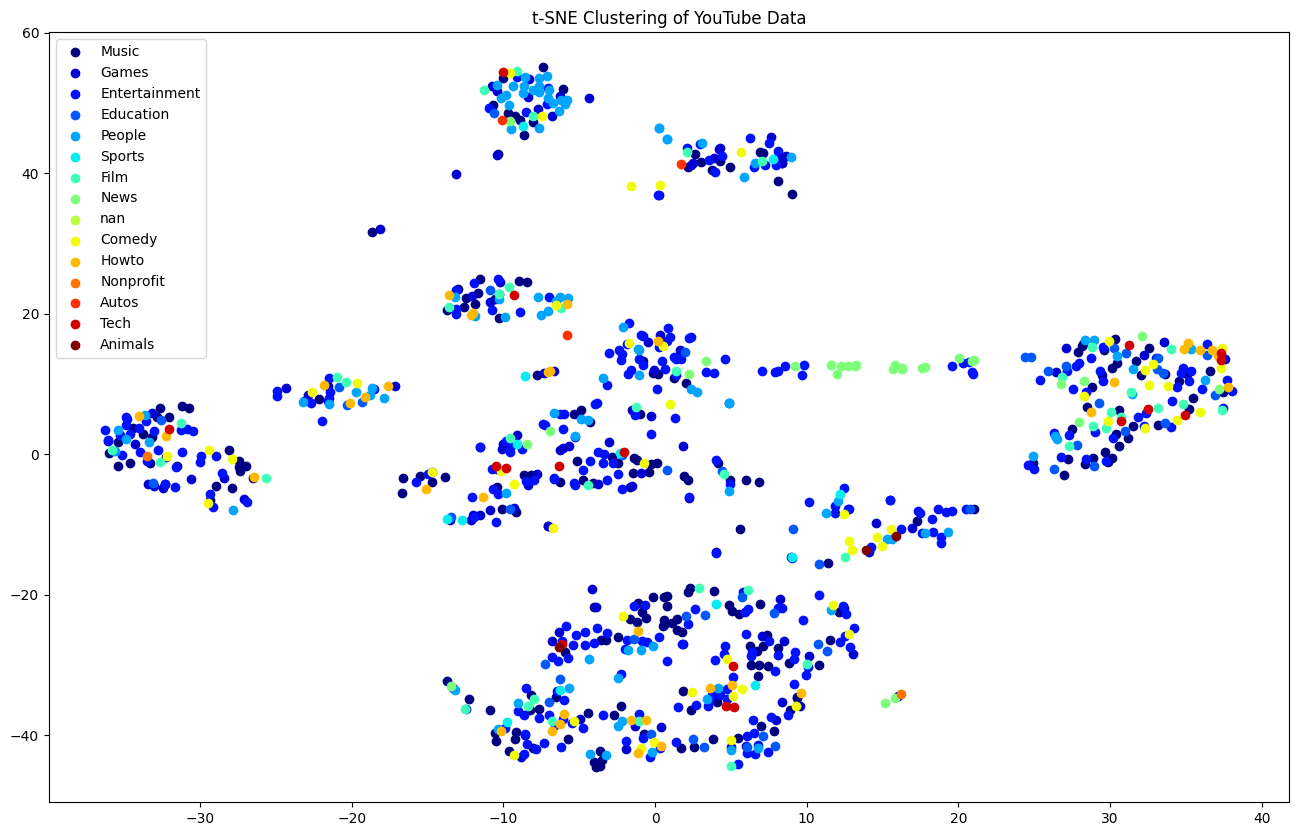

In [55]:

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(df_scaled)
plt.figure(figsize=(16,10))
plt.title("t-SNE Clustering of YouTube Data")

# Convert category labels to numbers
unique_categories = df['channel_type'].unique()
colors = [plt.cm.jet(i/float(len(unique_categories)-1)) for i in range(len(unique_categories))]

for i, category in enumerate(unique_categories):
    indices = df['channel_type'] == category
    plt.scatter(tsne_results[:, 0][indices], tsne_results[:, 1][indices], c=[colors[i]], label=category)

plt.legend()
plt.show()
